### Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random

from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/mental_health.csv', index_col=0)

In [4]:
df.shape

(53044, 2)

In [5]:
df.head()  # Display the first few rows of the dataframe

,statement,status
0.0,oh my gosh,Anxiety
1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3.0,I've shifted my focus to something else but I'...,Anxiety
4.0,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.info()  # Get a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 53044 entries, 0.0 to 53042.0
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df.isnull().sum()

statement    363
status         1
dtype: int64

In [8]:
df.dropna(inplace=True)  # Drop rows with any missing values

In [9]:
df.isnull().sum()  # Check again for missing values after dropping  

statement    0
status       0
dtype: int64

In [10]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

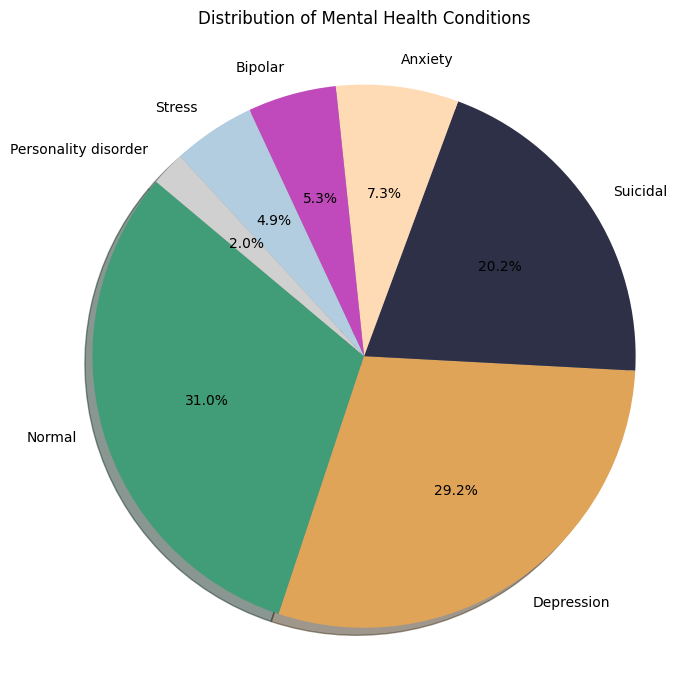

In [11]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [12]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Leave of absence at work Hello all!

I've been working for my sister's friends business for over a year now.

In the span of the last 6 months, I have had 3 major anxiety episodes of a week or longer.

Im having another bout of debilitating anxiety and decided that a leave of absence would be best for me to get better or help if I end up needing it.

I still feel guilty as I've been out a week already, but I know I shouldn't feel guilty.

Am I doing the right thing?

Status: Bipolar
Statement: In a deep depression My fiancé left me on Monday and I’m in a deep depression. She gave no sign that she was unhappy or anything and just left. I’m suffering badly and don’t want to be here right now. I don’t know what to do, I’ve tried talking to her but she wants nothing to do to with me. We had so many plans and dreams with each other. Last week we were looking at places to get married. I’m fucking miserable and don’t know what to do.

I called my provider but earlie

### Text Preprocessing

In [13]:
df.statement

0.0                                               oh my gosh
1.0        trouble sleeping, confused mind, restless hear...
2.0        All wrong, back off dear, forward doubt. Stay ...
3.0        I've shifted my focus to something else but I'...
4.0        I'm restless and restless, it's been a month n...
                                 ...                        
53038.0    Nobody takes me seriously I’ve (24M) dealt wit...
53039.0    selfishness  "I don't feel very good, it's lik...
53040.0    Is there any way to sleep better? I can't slee...
53041.0    Public speaking tips? Hi, all. I have to give ...
53042.0    I have really bad door anxiety! It's not about...
Name: statement, Length: 52681, dtype: object

In [14]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.075625          6.256013
std           834.586377          9.187292
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         27588.000000        430.000000


In [15]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [16]:
def text_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)
     # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
     # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text


In [17]:
# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(text_preprocessing)
df.head()

,statement,status,num_of_characters,num_of_sentences
0.0,oh gosh,Anxiety,10,1
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2
3.0,ive shifted focus something else im still worried,Anxiety,61,1
4.0,im restless restless month boy mean,Anxiety,72,2


In [18]:

# Download WordNet data (required for lemmatization)
nltk.download('wordnet', quiet=True)
print("WordNet lemmatizer ready!")
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

WordNet lemmatizer ready!


In [19]:
## Apply lemmatization
df['statement'] = df['statement'].apply(lambda x: lemmatizer.lemmatize(x))

In [20]:
df.head()

,statement,status,num_of_characters,num_of_sentences
0.0,oh gosh,Anxiety,10,1
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2
3.0,ive shifted focus something else im still worried,Anxiety,61,1
4.0,im restless restless month boy mean,Anxiety,72,2


In [21]:
## Tokenization

# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,statement,status,num_of_characters,num_of_sentences,tokens
0.0,oh gosh,Anxiety,10,1,"[oh, gosh]"
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ..."
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2,"[wrong, back, dear, forward, doubt, stay, rest..."
3.0,ive shifted focus something else im still worried,Anxiety,61,1,"[ive, shifted, focus, something, else, im, sti..."
4.0,im restless restless month boy mean,Anxiety,72,2,"[im, restless, restless, month, boy, mean]"


In [22]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed
0.0,oh gosh,Anxiety,10,1,"[oh, gosh]",oh gosh
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart tune
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2,"[wrong, back, dear, forward, doubt, stay, rest...",wrong back dear forward doubt stay restless re...
3.0,ive shifted focus something else im still worried,Anxiety,61,1,"[ive, shifted, focus, something, else, im, sti...",ive shift focu someth els im still worri
4.0,im restless restless month boy mean,Anxiety,72,2,"[im, restless, restless, month, boy, mean]",im restless restless month boy mean


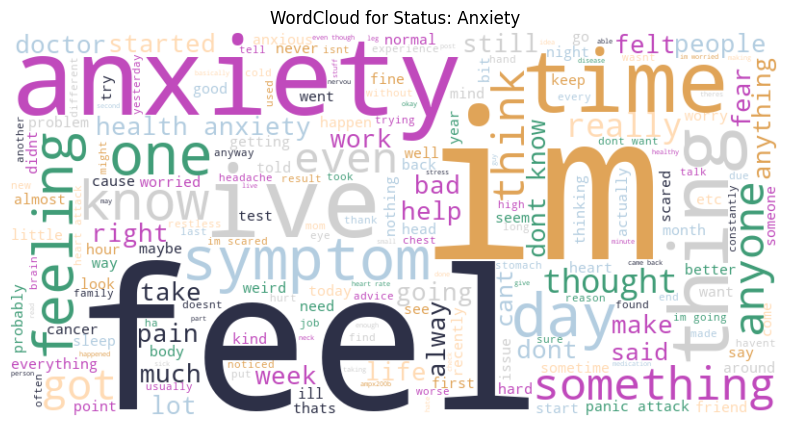

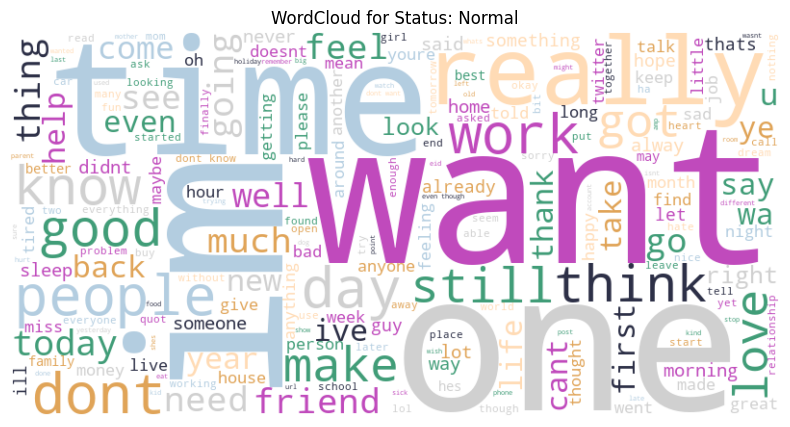

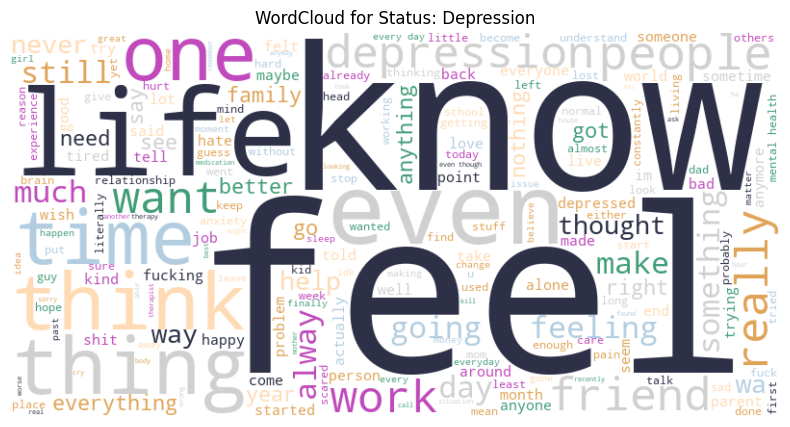

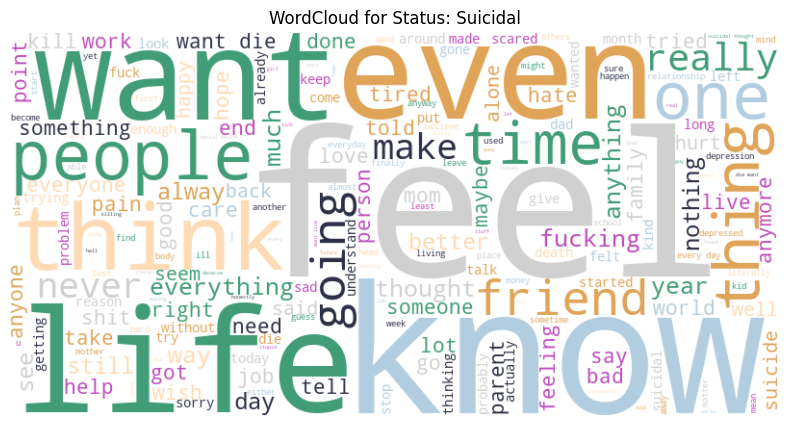

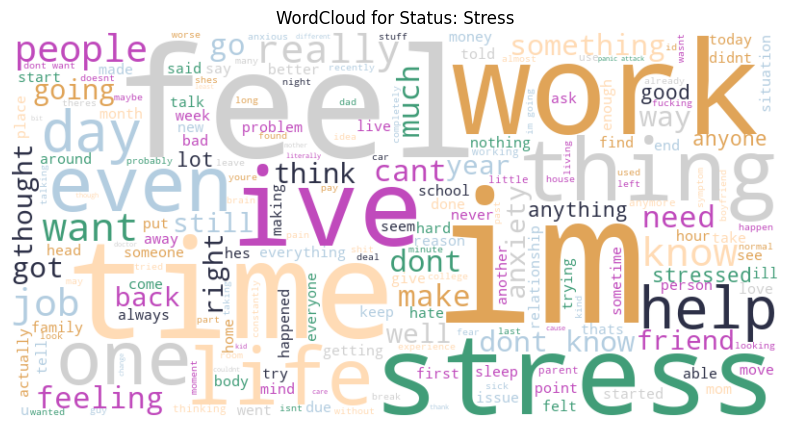

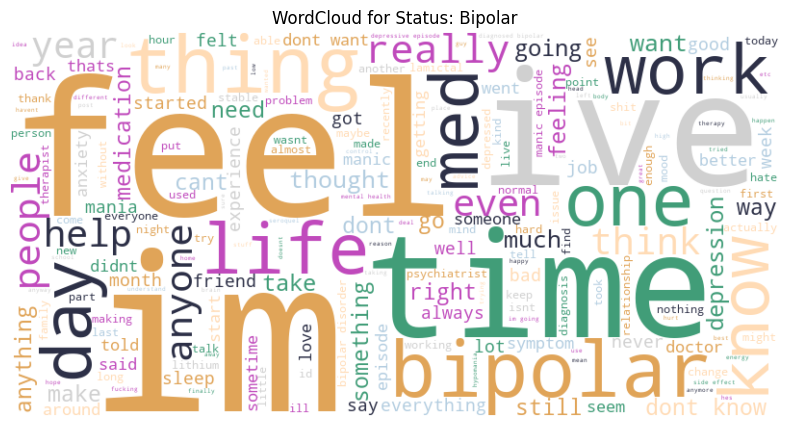

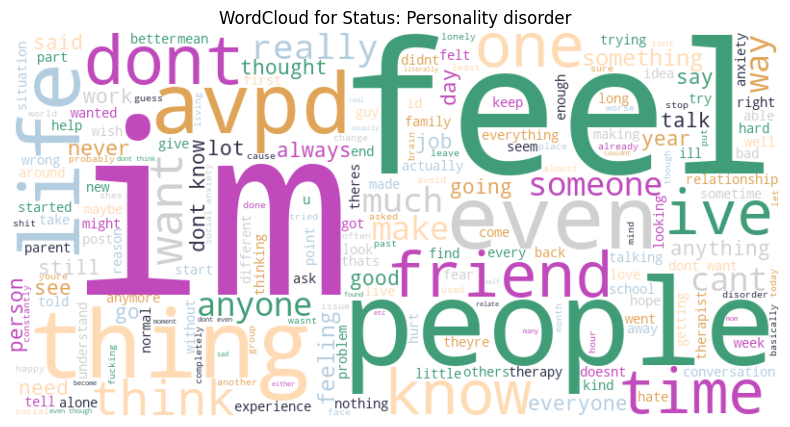

In [23]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [24]:
##Data Preprocessing

In [25]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [26]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [28]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [29]:
y_train

array([2, 3, 2, ..., 1, 2, 3])

In [30]:
##Model Traning and Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [35]:
# Define a dictionary of classifiers with their specific parameters.
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
     'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
     'KNN': KNeighborsClassifier(n_neighbors=5),
    # 'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_split=5, random_state=101),
    # 'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='hist')
}



For Bernoulli Naive Bayes
Accuracy: 0.6537914017272468
                      precision    recall  f1-score   support

             Anxiety       0.72      0.62      0.67       768
             Bipolar       0.72      0.61      0.66       556
          Depression       0.71      0.48      0.57      3081
              Normal       0.67      0.93      0.78      3269
Personality disorder       0.64      0.53      0.58       215
              Stress       0.44      0.56      0.49       517
            Suicidal       0.59      0.54      0.56      2131

            accuracy                           0.65     10537
           macro avg       0.64      0.61      0.62     10537
        weighted avg       0.66      0.65      0.64     10537



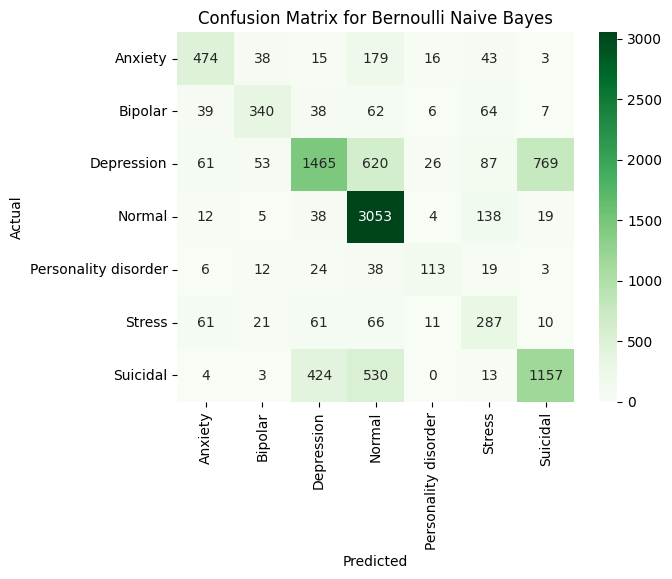



For Decision Tree
Accuracy: 0.6753345354465218
                      precision    recall  f1-score   support

             Anxiety       0.60      0.59      0.59       768
             Bipolar       0.67      0.43      0.53       556
          Depression       0.67      0.69      0.68      3081
              Normal       0.77      0.92      0.84      3269
Personality disorder       0.54      0.32      0.40       215
              Stress       0.51      0.39      0.44       517
            Suicidal       0.55      0.48      0.52      2131

            accuracy                           0.68     10537
           macro avg       0.62      0.55      0.57     10537
        weighted avg       0.66      0.68      0.66     10537



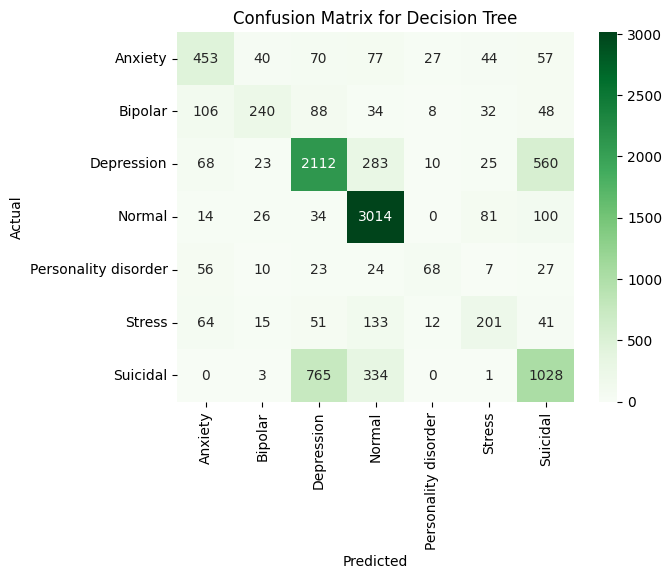



For Logistic Regression
Accuracy: 0.7541045838473949
                      precision    recall  f1-score   support

             Anxiety       0.81      0.78      0.79       768
             Bipolar       0.85      0.81      0.83       556
          Depression       0.70      0.70      0.70      3081
              Normal       0.86      0.92      0.89      3269
Personality disorder       0.79      0.68      0.73       215
              Stress       0.63      0.53      0.58       517
            Suicidal       0.64      0.61      0.62      2131

            accuracy                           0.75     10537
           macro avg       0.75      0.72      0.73     10537
        weighted avg       0.75      0.75      0.75     10537



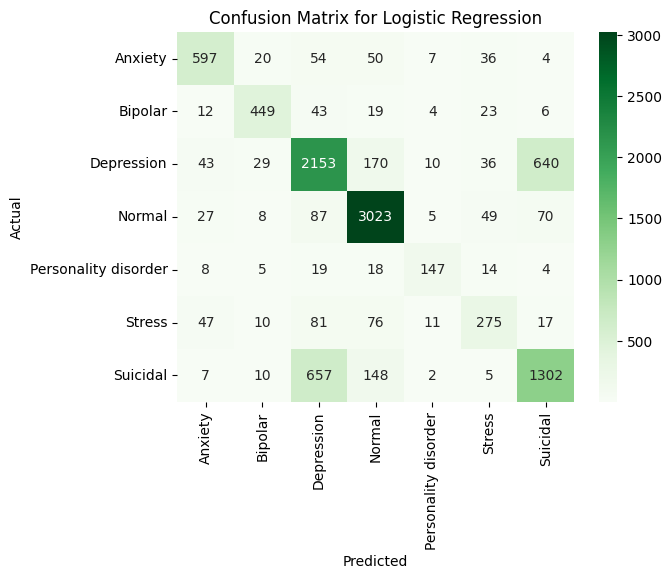



For KNN
Accuracy: 0.5155167504982443
                      precision    recall  f1-score   support

             Anxiety       0.20      0.16      0.18       768
             Bipolar       0.17      0.14      0.15       556
          Depression       0.47      0.59      0.52      3081
              Normal       0.77      0.85      0.81      3269
Personality disorder       0.10      0.05      0.06       215
              Stress       0.29      0.26      0.28       517
            Suicidal       0.34      0.23      0.27      2131

            accuracy                           0.52     10537
           macro avg       0.33      0.33      0.32     10537
        weighted avg       0.49      0.52      0.49     10537



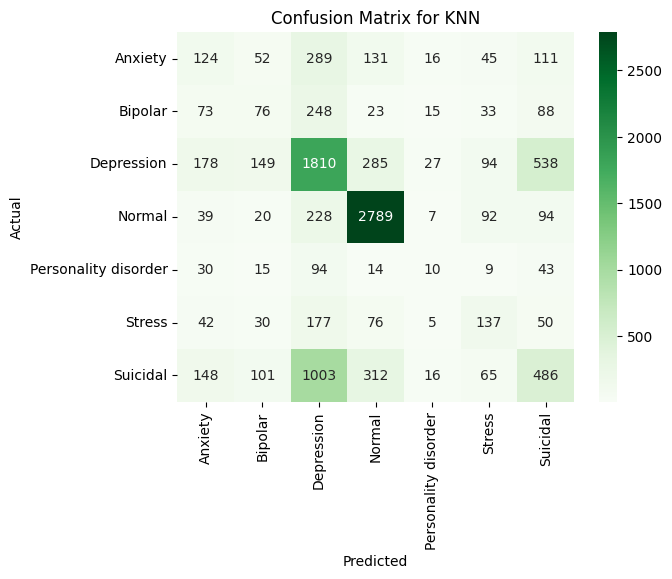

In [36]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_combined, y_train)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

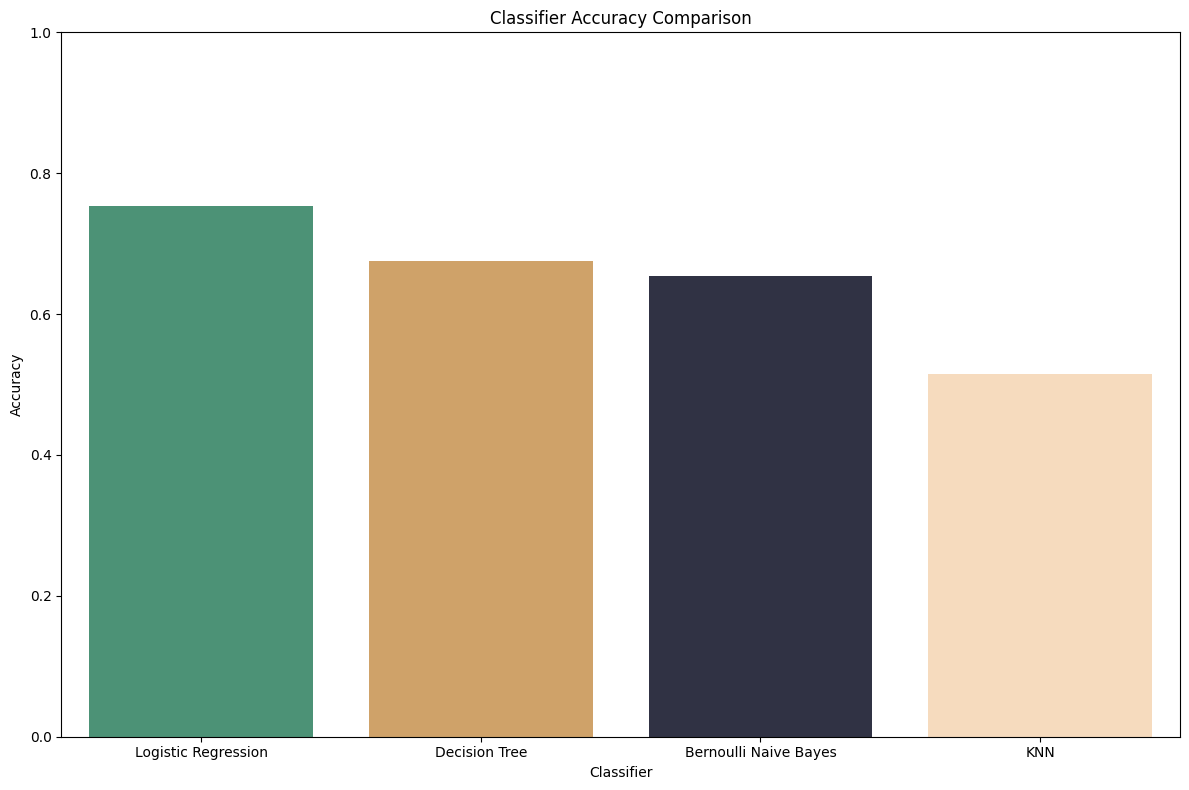

In [37]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()